# Download Data

Download the BTC-USD Dataset from Perplexity Finance.

Save the file into the directory ./data/raw/

# Initialization

In [1]:
%load_ext dotenv
%dotenv 

In [ ]:
#%pip install mplfinance
%pip install xgboost

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import sys
from glob import glob


from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
#import mplfinance as mpf
import seaborn as sns
import yfinance as yf


# Add the src directory to the path
src_dir = os.getenv('SRC_DIR')
if src_dir is None:
	# Fallback: assume notebooks folder is one level below project root
	project_root = os.path.dirname(os.getcwd())
	src_dir = os.path.join(project_root, 'src')
print(f"Adding to path: {src_dir}")
sys.path.append(src_dir)

from utils.logger import get_logger
_logs = get_logger(__name__)

Adding to path: ../src/


## Importing Dataset

In [4]:
import hashlib

# Load data
# Define ordered column names to enforce consistent schema (overrides original file header)
columns = [
    'Date', 
    'Close',          
    'Open', 
    'High',                
    'Low', 
    'Volume'
]

btc_file = os.getenv("BTC_DATA")

# Read the raw CSV:
# - header=0 reads the first line (original names) but they are replaced by 'columns'
# - names=columns ensures consistent snake_case naming initialize above
btc_dt = (pd.read_csv(btc_file, header = 0, names = columns))

# Save processed data to a new CSV folder and appeand file name with hash value
    
# Create a hash of the DataFrame
df_hash = hashlib.md5(btc_dt.to_csv(index=False).encode()).hexdigest()
processed_btc_file = os.getenv("PROCESSED_BTC_DATA").replace(".csv", f"_{df_hash}.csv")
btc_dt.to_csv(processed_btc_file, index=False)

# Log the completion of data loading and feature creation and record file name
_logs.info("Loaded BTC-USD dataset into DataFrame.")
_logs.info(f"Processed BTC-USD dataset saved to: {processed_btc_file}")

2025-11-06 16:53:30,316, 2713969401.py, 29, INFO, Loaded BTC-USD dataset into DataFrame.
2025-11-06 16:53:30,317, 2713969401.py, 30, INFO, Processed BTC-USD dataset saved to: ../data/processed/btc_processed_8d4c513d70341c9eb8c09d7c4aa06be1.csv
2025-11-06 16:53:30,317, 2713969401.py, 30, INFO, Processed BTC-USD dataset saved to: ../data/processed/btc_processed_8d4c513d70341c9eb8c09d7c4aa06be1.csv


# Exploratory Data Analysis

In [5]:
# Observe the data structure
btc_dt.info()

# Print the shape of the DataFrame
print(f"BTC-USD DataFrame shape: {btc_dt.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1827 non-null   object 
 1   Close   1827 non-null   float64
 2   Open    1827 non-null   float64
 3   High    1827 non-null   float64
 4   Low     1827 non-null   float64
 5   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 85.8+ KB
BTC-USD DataFrame shape: (1827, 6)


In [6]:
# Check for missing values
btc_dt.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
dtype: int64

In [7]:
# Display the first few rows
print("First few rows of BTC-USD DataFrame:")
btc_dt.head()


First few rows of BTC-USD DataFrame:


,Date,Close,Open,High,Low,Volume
0,2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439
1,2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971
2,2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706
3,2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029
4,2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566


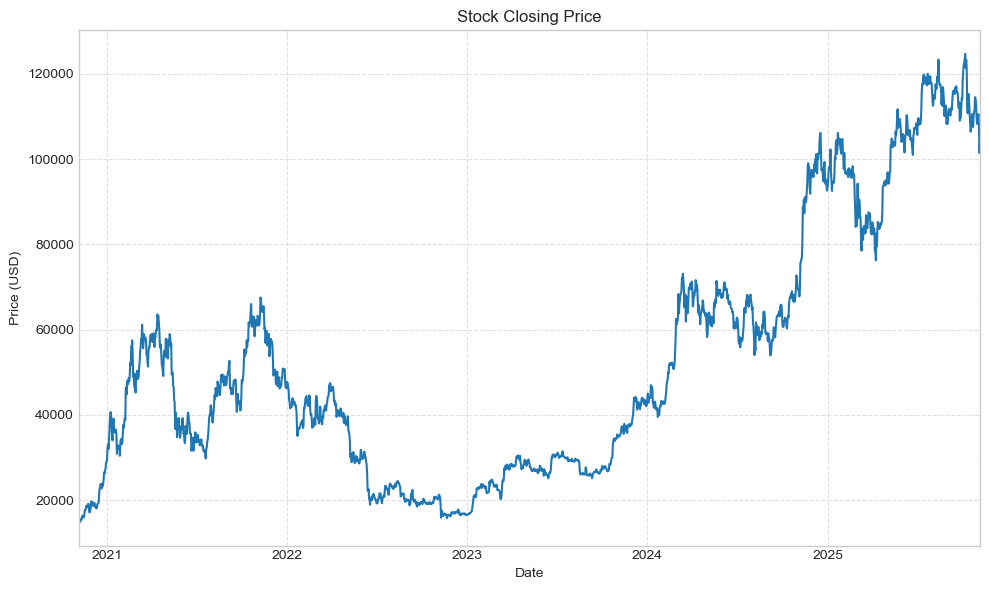

In [8]:
# Style sheet
plt.style.use('seaborn-v0_8-whitegrid')


# Ensure Date is datetime
btc_dt['Date'] = pd.to_datetime(btc_dt['Date'])
# Set date as index
btc_dt = btc_dt.set_index('Date')


btc_dt['Close'].plot(figsize=(10, 6), title='Stock Closing Price')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

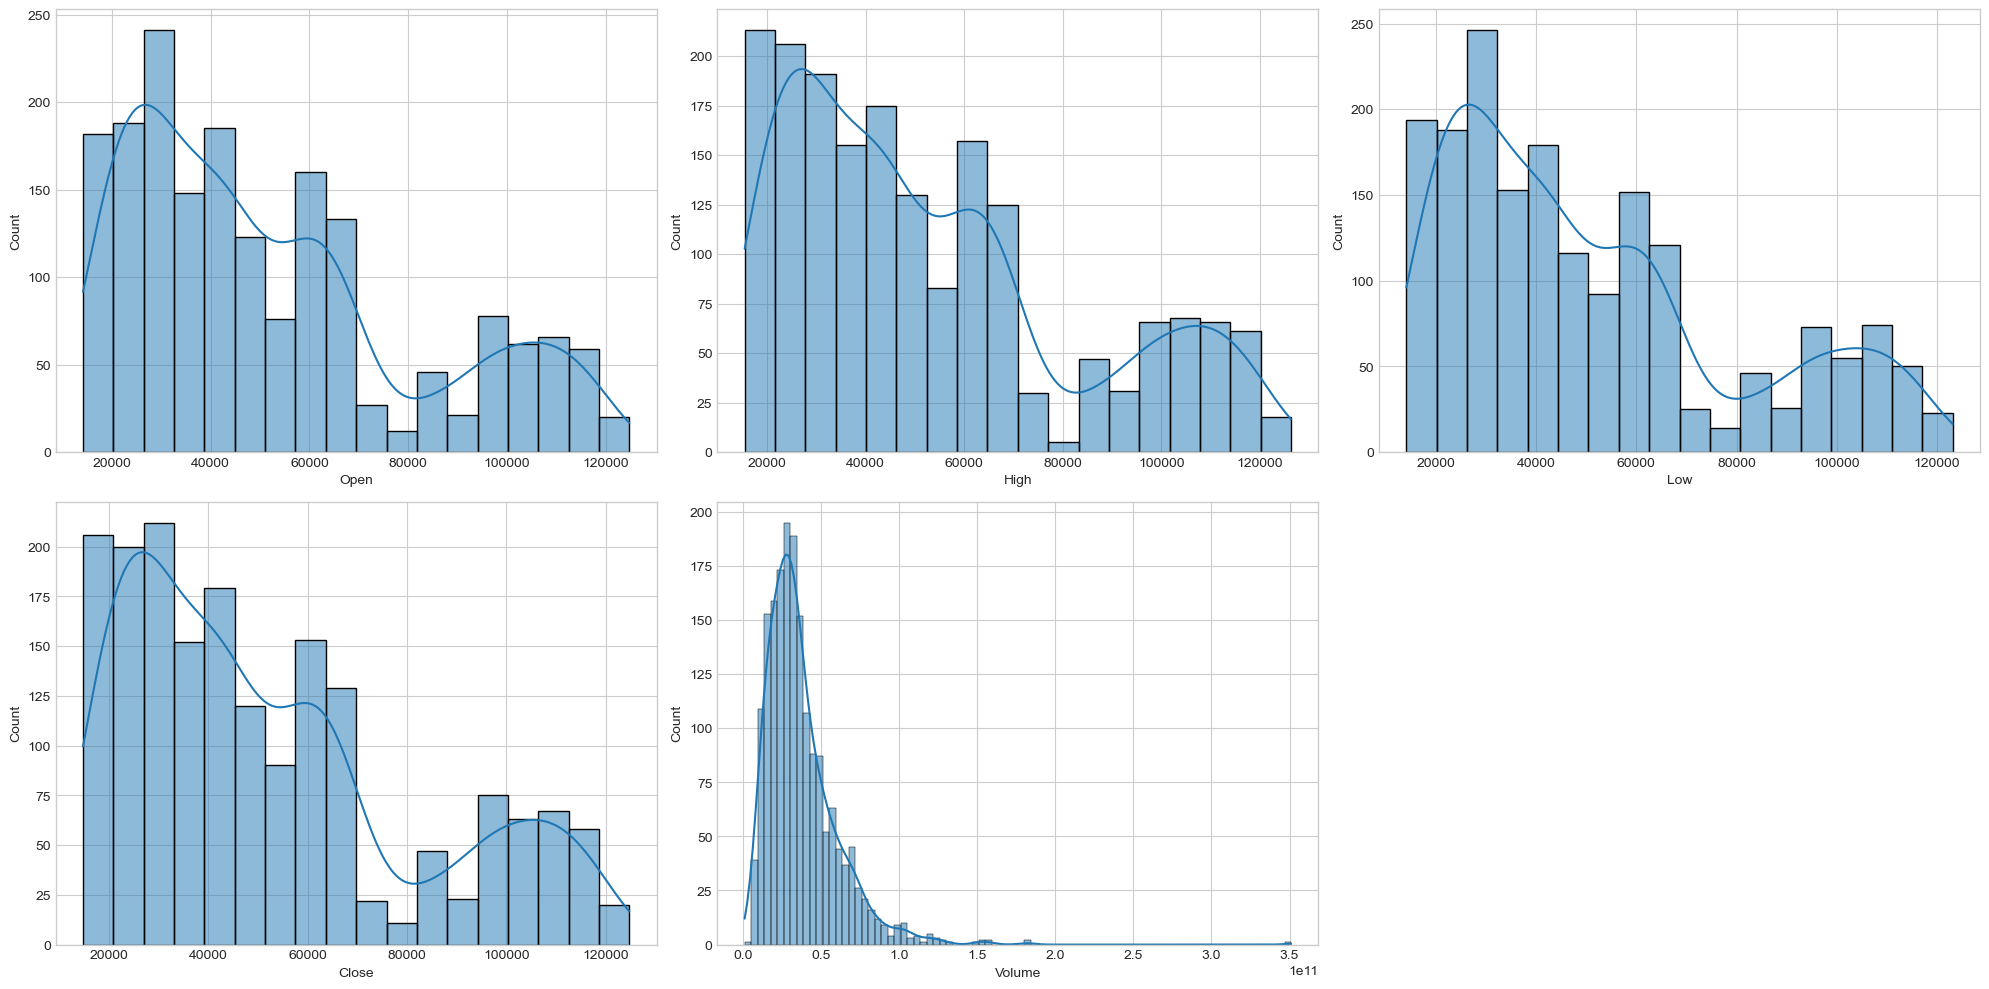

In [9]:
# Distribution Plots
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.figure(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2, 3, i+1)
    sb.histplot(btc_dt[col], kde=True)  # replaces distplot

plt.tight_layout()
plt.show()

# Feature Engineering

In [10]:
# Extract year, month, day from the DatetimeIndex
btc_dt['Year'] = btc_dt.index.year
btc_dt['Month'] = btc_dt.index.month
btc_dt['Day'] = btc_dt.index.day

btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day
Date,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9


In [11]:
import numpy as np

btc_dt['is_quarter_end'] = np.where(btc_dt['Month']%3==0,1,0)
btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end
Date,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0


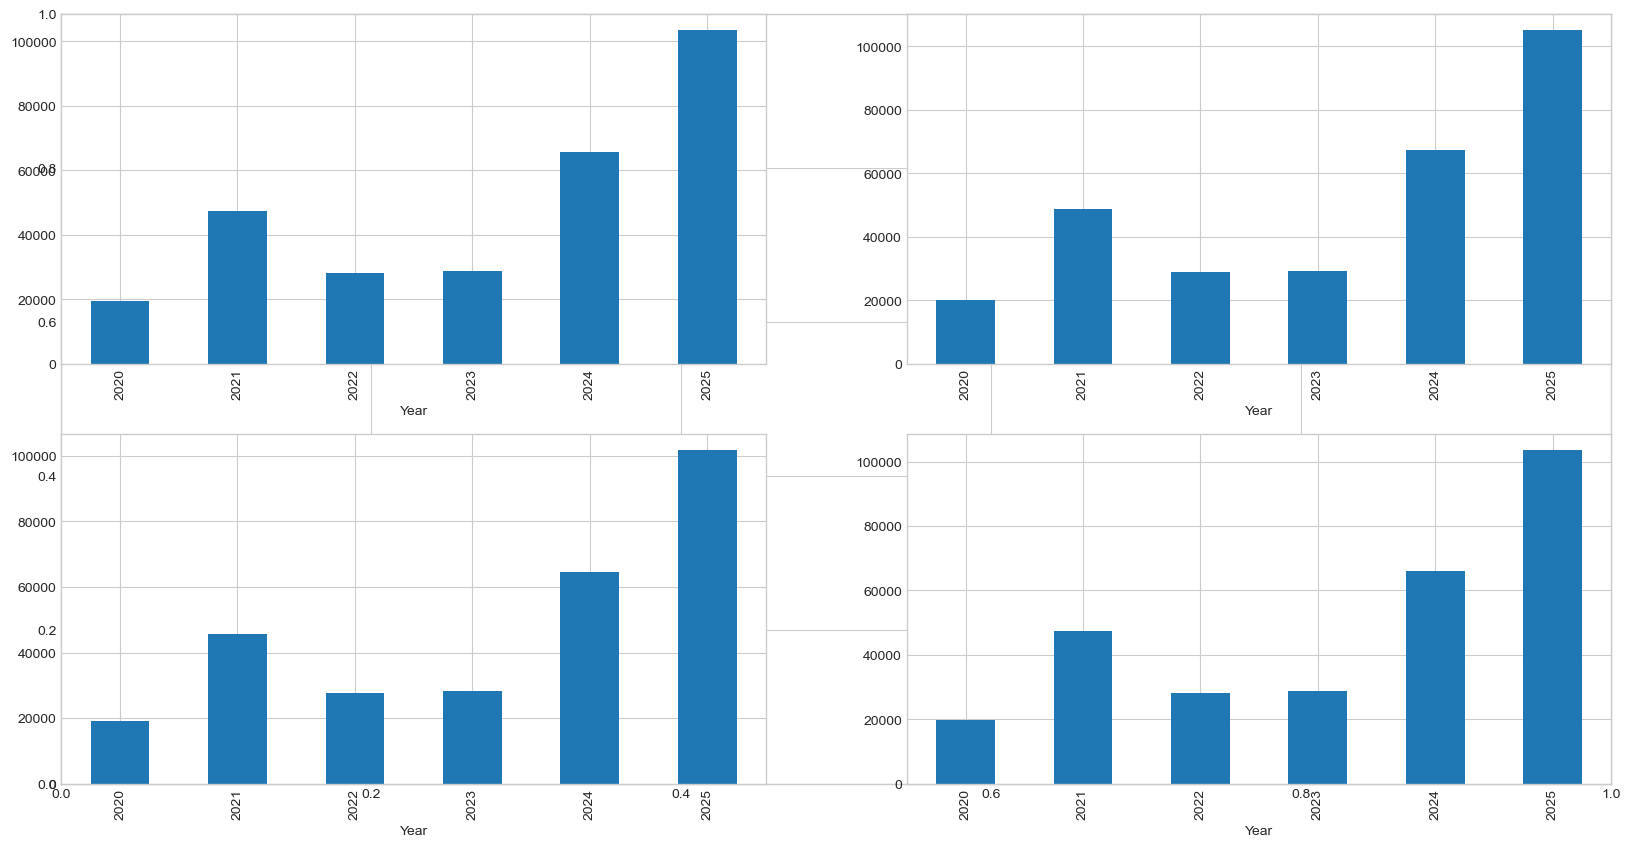

In [12]:
data_grouped = btc_dt.groupby('Year').mean()
plt.subplots(figsize=(20,10))

for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [13]:
# Signal whether to buy or not 
btc_dt['Open-Close']  = btc_dt['Open'] - btc_dt['Close']
btc_dt['Low-High']  = btc_dt['Low'] - btc_dt['High']

# Create target column with 1% price sensitivity
btc_dt['Target'] = np.where(btc_dt['Close'].shift(-1) > btc_dt['Close'] * 1.01, 1, 0)

print(f"Price Sensitivity: 1% (0.01)")
print(f"Bullish signals (1): {btc_dt['Target'].sum()} ({btc_dt['Target'].sum()/len(btc_dt)*100:.2f}%)")
print(f"Bearish signals (0): {(btc_dt['Target']==0).sum()} ({(btc_dt['Target']==0).sum()/len(btc_dt)*100:.2f}%)")


Price Sensitivity: 1% (0.01)
Bullish signals (1): 593 (32.46%)
Bearish signals (0): 1234 (67.54%)


In [14]:
btc_dt.head

<bound method NDFrame.head of                 Close       Open       High        Low        Volume  Year  \
Date                                                                         
2020-11-05   15608.21   14165.86   15775.00   14115.00   40856321439  2020   
2020-11-06   15599.95   15608.06   15977.67   15190.36   39837841971  2020   
2020-11-07   14834.09   15599.95   15779.24   14310.00   35024953706  2020   
2020-11-08   15482.90   14834.09   15666.00   14721.90   26632075029  2020   
2020-11-09   15342.25   15482.89   15856.90   14817.14   34149115566  2020   
...               ...        ...        ...        ...           ...   ...   
2025-11-01  110052.25  109555.63  110500.00  109342.47   34284209459  2025   
2025-11-02  110536.01  110052.25  111221.99  108800.00   34284209459  2025   
2025-11-03  106557.98  110533.83  110749.00  105271.67   74247200768  2025   
2025-11-04  101468.15  106557.98  107269.85   98892.97  110967000000  2025   
2025-11-05  103960.89  101468.16  

In [15]:
# Technical Analysis Features

# Moving Averages
btc_dt['MA_7'] = btc_dt['Close'].rolling(window=7).mean()
btc_dt['MA_14'] = btc_dt['Close'].rolling(window=14).mean()
btc_dt['MA_21'] = btc_dt['Close'].rolling(window=21).mean()
btc_dt['MA_50'] = btc_dt['Close'].rolling(window=50).mean()
btc_dt['MA_200'] = btc_dt['Close'].rolling(window=200).mean()

# Exponential Moving Averages
btc_dt['EMA_12'] = btc_dt['Close'].ewm(span=12, adjust=False).mean()
btc_dt['EMA_26'] = btc_dt['Close'].ewm(span=26, adjust=False).mean()

# MACD (Moving Average Convergence Divergence)
btc_dt['MACD'] = btc_dt['EMA_12'] - btc_dt['EMA_26']
btc_dt['MACD_Signal'] = btc_dt['MACD'].ewm(span=9, adjust=False).mean()
btc_dt['MACD_Histogram'] = btc_dt['MACD'] - btc_dt['MACD_Signal']

# Relative Strength Index (RSI)
delta = btc_dt['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
btc_dt['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
btc_dt['BB_Middle'] = btc_dt['Close'].rolling(window=20).mean()
bb_std = btc_dt['Close'].rolling(window=20).std()
btc_dt['BB_Upper'] = btc_dt['BB_Middle'] + (bb_std * 2)
btc_dt['BB_Lower'] = btc_dt['BB_Middle'] - (bb_std * 2)
btc_dt['BB_Width'] = btc_dt['BB_Upper'] - btc_dt['BB_Lower']

# Price Rate of Change (ROC)
btc_dt['ROC'] = ((btc_dt['Close'] - btc_dt['Close'].shift(10)) / btc_dt['Close'].shift(10)) * 100

# Average True Range (ATR) - Volatility Indicator
high_low = btc_dt['High'] - btc_dt['Low']
high_close = np.abs(btc_dt['High'] - btc_dt['Close'].shift())
low_close = np.abs(btc_dt['Low'] - btc_dt['Close'].shift())
true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
btc_dt['ATR'] = true_range.rolling(window=14).mean()

# Stochastic Oscillator
low_14 = btc_dt['Low'].rolling(window=14).min()
high_14 = btc_dt['High'].rolling(window=14).max()
btc_dt['Stochastic_%K'] = 100 * ((btc_dt['Close'] - low_14) / (high_14 - low_14))
btc_dt['Stochastic_%D'] = btc_dt['Stochastic_%K'].rolling(window=3).mean()

# On-Balance Volume (OBV)
btc_dt['OBV'] = (np.sign(btc_dt['Close'].diff()) * btc_dt['Volume']).fillna(0).cumsum()

# Volume Rate of Change
btc_dt['Volume_ROC'] = ((btc_dt['Volume'] - btc_dt['Volume'].shift(5)) / btc_dt['Volume'].shift(5)) * 100

# Price momentum
btc_dt['Momentum'] = btc_dt['Close'] - btc_dt['Close'].shift(4)

# Percentage change features
btc_dt['Daily_Return'] = btc_dt['Close'].pct_change() * 100
btc_dt['Volatility_10'] = btc_dt['Daily_Return'].rolling(window=10).std()
btc_dt['Volatility_30'] = btc_dt['Daily_Return'].rolling(window=30).std()

_logs.info(f"Technical analysis features created. Dataset now has {btc_dt.shape[1]} features.")

2025-11-06 16:54:40,968, 4133966.py, 63, INFO, Technical analysis features created. Dataset now has 37 features.


In [16]:
btc_dt.head()

,Close,Open,High,Low,Volume,Year,Month,Day,is_quarter_end,Open-Close,...,ROC,ATR,Stochastic_%K,Stochastic_%D,OBV,Volume_ROC,Momentum,Daily_Return,Volatility_10,Volatility_30
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-05,15608.21,14165.86,15775.00,14115.00,40856321439,2020,11,5,0,-1442.35,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN
2020-11-06,15599.95,15608.06,15977.67,15190.36,39837841971,2020,11,6,0,8.11,...,NaN,NaN,NaN,NaN,-3.983784e+10,NaN,NaN,-0.052921,NaN,NaN
2020-11-07,14834.09,15599.95,15779.24,14310.00,35024953706,2020,11,7,0,765.86,...,NaN,NaN,NaN,NaN,-7.486280e+10,NaN,NaN,-4.909375,NaN,NaN
2020-11-08,15482.90,14834.09,15666.00,14721.90,26632075029,2020,11,8,0,-648.81,...,NaN,NaN,NaN,NaN,-4.823072e+10,NaN,NaN,4.373777,NaN,NaN
2020-11-09,15342.25,15482.89,15856.90,14817.14,34149115566,2020,11,9,0,140.64,...,NaN,NaN,NaN,NaN,-8.237984e+10,NaN,-265.96,-0.908422,NaN,NaN


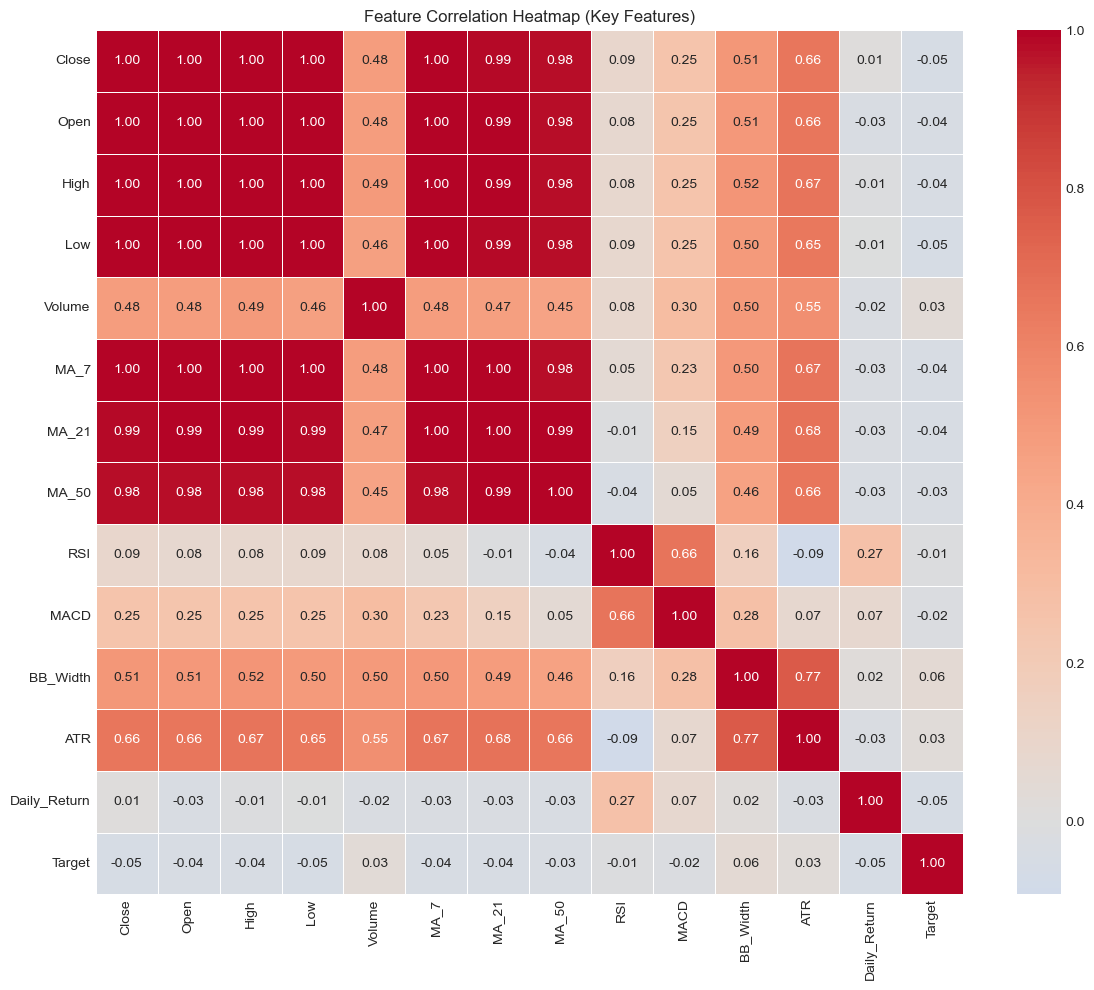

In [17]:
# Correlation Heatmap - simplified version
# Selecting most important features to reduce visual clutter
important_features = ['Close', 'Open', 'High', 'Low', 'Volume', 
                      'MA_7', 'MA_21', 'MA_50', 'RSI', 'MACD', 
                      'BB_Width', 'ATR', 'Daily_Return', 'Target']

plt.figure(figsize=(12, 10))
sb.heatmap(btc_dt[important_features].corr(), annot=True, cbar=True, fmt='.2f', 
           cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Feature Correlation Heatmap (Key Features)')
plt.tight_layout()
plt.show()


# Model Development


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import warnings

warnings.filterwarnings('ignore')

# Prepare data - drop rows with NaN values and select features
ml_data = btc_dt.dropna().copy()

# Select features for modeling (excluding target and date-related features)
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Open-Close', 'Low-High',
                'MA_7', 'MA_14', 'MA_21', 'MA_50', 'MA_200',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D',
                'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return',
                'Volatility_10', 'Volatility_30']

X = ml_data[feature_cols]
y = ml_data['Target']

# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

_logs.info(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

# 1. Logistic Regression
_logs.info("Training Logistic Regression model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_prob = lr_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("LOGISTIC REGRESSION RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# 2. Random Forest
_logs.info("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_prob = rf_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("RANDOM FOREST RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# 3. XGBoost
_logs.info("Training XGBoost model...")
xgb_model = XGBClassifier(n_estimators=100, random_state=42, max_depth=5, learning_rate=0.1, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("=" * 60)
print("XGBOOST RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, xgb_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))


_logs.info("Model training completed successfully.")


2025-11-06 16:54:53,328, 2794898342.py, 35, INFO, Training set size: 1302, Test set size: 326
2025-11-06 16:54:53,329, 2794898342.py, 38, INFO, Training Logistic Regression model...
2025-11-06 16:54:53,329, 2794898342.py, 38, INFO, Training Logistic Regression model...
2025-11-06 16:54:53,380, 2794898342.py, 53, INFO, Training Random Forest model...
2025-11-06 16:54:53,380, 2794898342.py, 53, INFO, Training Random Forest model...


LOGISTIC REGRESSION RESULTS
Accuracy: 0.6963
ROC-AUC Score: 0.5764

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       238
           1       0.37      0.18      0.24        88

    accuracy                           0.70       326
   macro avg       0.56      0.53      0.53       326
weighted avg       0.64      0.70      0.66       326



2025-11-06 16:54:54,238, 2794898342.py, 68, INFO, Training XGBoost model...


RANDOM FOREST RESULTS
Accuracy: 0.5184
ROC-AUC Score: 0.5034

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       238
           1       0.29      0.52      0.37        88

    accuracy                           0.52       326
   macro avg       0.52      0.52      0.49       326
weighted avg       0.62      0.52      0.55       326



2025-11-06 16:54:54,739, 2794898342.py, 83, INFO, Model training completed successfully.


XGBOOST RESULTS
Accuracy: 0.7178
ROC-AUC Score: 0.5866

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93      0.83       238
           1       0.43      0.14      0.21        88

    accuracy                           0.72       326
   macro avg       0.59      0.53      0.52       326
weighted avg       0.66      0.72      0.66       326



In [19]:
def prepare_data_for_modeling(btc_dt, feature_cols, test_size=0.2, random_state=42):
    """Prepare data by dropping NaN values and splitting into train/test sets."""
    ml_data = btc_dt.dropna().copy()
    X = ml_data[feature_cols]
    y = ml_data['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    _logs.info(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test, ml_data

def scale_features(X_train, X_test):
    """Scale features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def train_logistic_regression(X_train_scaled, y_train, random_state=42):
    """Train Logistic Regression model."""
    _logs.info("Training Logistic Regression model...")
    lr_model = LogisticRegression(random_state=random_state, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    return lr_model

def train_random_forest(X_train_scaled, y_train, random_state=42):
    """Train Random Forest model."""
    _logs.info("Training Random Forest model...")
    rf_model = RandomForestClassifier(
        n_estimators=100, random_state=random_state, 
        max_depth=10, min_samples_split=5
    )
    rf_model.fit(X_train_scaled, y_train)
    return rf_model

def train_xgboost(X_train_scaled, y_train, random_state=42):
    """Train XGBoost model."""
    _logs.info("Training XGBoost model...")
    xgb_model = XGBClassifier(
        n_estimators=100, random_state=random_state, 
        max_depth=5, learning_rate=0.1, eval_metric='logloss'
    )
    xgb_model.fit(X_train_scaled, y_train)
    return xgb_model

def evaluate_model(model, X_test_scaled, y_test, model_name):
    """Evaluate model and print results."""
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    
    print("=" * 60)
    print(f"{model_name} RESULTS")
    print("=" * 60)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, y_prob


# Feature columns for modeling
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 
                'Open-Close', 'Low-High',
                'MA_7', 'MA_14', 'MA_21', 'MA_50', 'MA_200',
                'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
                'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'BB_Width',
                'ROC', 'ATR', 'Stochastic_%K', 'Stochastic_%D',
                'OBV', 'Volume_ROC', 'Momentum', 'Daily_Return',
                'Volatility_10', 'Volatility_30']

# Prepare and scale data
X_train, X_test, y_train, y_test, ml_data = prepare_data_for_modeling(btc_dt, feature_cols)
X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)

# Train models
lr_model = train_logistic_regression(X_train_scaled, y_train)
rf_model = train_random_forest(X_train_scaled, y_train)
xgb_model = train_xgboost(X_train_scaled, y_train)

# Evaluate models
lr_pred, lr_prob = evaluate_model(lr_model, X_test_scaled, y_test, "LOGISTIC REGRESSION")
rf_pred, rf_prob = evaluate_model(rf_model, X_test_scaled, y_test, "RANDOM FOREST")
xgb_pred, xgb_prob = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBOOST")

_logs.info("Model training completed successfully.")


2025-11-06 16:55:02,989, 1151701797.py, 11, INFO, Training set size: 1302, Test set size: 326
2025-11-06 16:55:03,000, 1151701797.py, 23, INFO, Training Logistic Regression model...
2025-11-06 16:55:03,000, 1151701797.py, 23, INFO, Training Logistic Regression model...
2025-11-06 16:55:03,280, 1151701797.py, 30, INFO, Training Random Forest model...
2025-11-06 16:55:03,280, 1151701797.py, 30, INFO, Training Random Forest model...
2025-11-06 16:55:04,031, 1151701797.py, 40, INFO, Training XGBoost model...
2025-11-06 16:55:04,031, 1151701797.py, 40, INFO, Training XGBoost model...
2025-11-06 16:55:04,512, 1151701797.py, 88, INFO, Model training completed successfully.
2025-11-06 16:55:04,512, 1151701797.py, 88, INFO, Model training completed successfully.


LOGISTIC REGRESSION RESULTS
Accuracy: 0.6963
ROC-AUC Score: 0.5764

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       238
           1       0.37      0.18      0.24        88

    accuracy                           0.70       326
   macro avg       0.56      0.53      0.53       326
weighted avg       0.64      0.70      0.66       326

RANDOM FOREST RESULTS
Accuracy: 0.5184
ROC-AUC Score: 0.5034

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       238
           1       0.29      0.52      0.37        88

    accuracy                           0.52       326
   macro avg       0.52      0.52      0.49       326
weighted avg       0.62      0.52      0.55       326

XGBOOST RESULTS
Accuracy: 0.7178
ROC-AUC Score: 0.5866

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.93   

## LSTM

An LSTM learns how Bitcoin behaves over time by looking at patterns in the past, remembering the important parts, and using that memory to estimate where price is heading next.


- Goal/label: Binary target = 1 if tomorrow’s close > today by >1%, else 0.
- Inputs: 31 technical features per day (price/volume + indicators).
- Temporal framing: Predict the next day’s label using a 10-day lookback window of features.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2025-11-06 16:55:20.789346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 16:55:24,412, 2100689613.py, 39, INFO, LSTM Training sequences shape: (1292, 10, 32)
2025-11-06 16:55:24,413, 2100689613.py, 40, INFO, LSTM Test sequences shape: (316, 10, 32)
2025-11-06 16:55:24,418, 2100689613.py, 44, INFO, LSTM model architecture:
2025-11-06 16:55:24,412, 2100689613.py, 39, INFO, LSTM Training sequences shape: (1292, 10, 32)
2025-11-06 16:55:24,413, 2100689613.py, 40, INFO, LSTM Test sequences shape: (316, 10, 32)
2025-11-06 16:55:24,418, 2100689613.py, 44, INFO, LSTM model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,793 (147.63 KB)

 Trainable params: 37,793 (147.63 KB)

 Non-trainable params: 0 (0.00 B)

2025-11-06 16:55:24,704, 2100689613.py, 79, INFO, Training LSTM model:


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6254 - loss: 0.6528 - val_accuracy: 0.6023 - val_loss: 0.6706
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6254 - loss: 0.6528 - val_accuracy: 0.6023 - val_loss: 0.6706
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6786 - loss: 0.6386 - val_accuracy: 0.6757 - val_loss: 0.6465
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6786 - loss: 0.6386 - val_accuracy: 0.6757 - val_loss: 0.6465
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6786 - loss: 0.6237 - val_accuracy: 0.6718 - val_loss: 0.6471
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6786 - loss: 0.6237 - val_accuracy: 0.6718 - val_loss: 0.6471
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6786 - loss: 0.6251 - val_accuracy: 0.6680 - val_loss: 0.6493
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6786 - loss: 0.6251 - val_accuracy: 0.6680 - v

2025-11-06 16:55:38,641, 2100689613.py, 103, INFO, LSTM model training completed successfully.


LSTM RESULTS
Accuracy: 0.7278
ROC-AUC Score: 0.5139

Classification Report:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       230
           1       0.00      0.00      0.00        86

    accuracy                           0.73       316
   macro avg       0.36      0.50      0.42       316
weighted avg       0.53      0.73      0.61       316



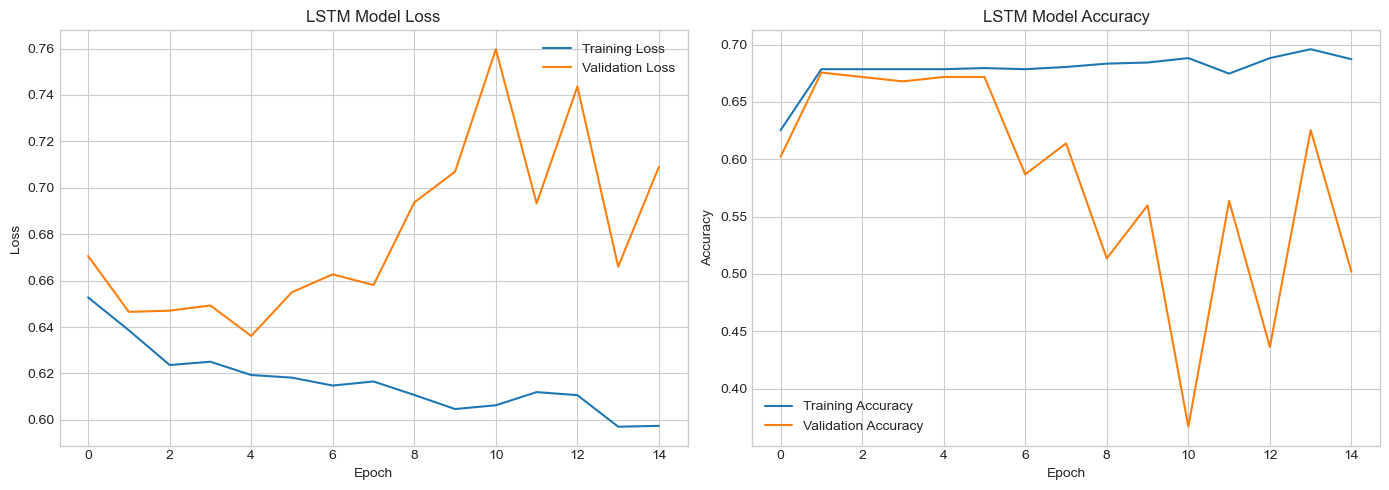

In [20]:
%pip install tensorflow
# LSTM Model for Time Series Classification

# Features (31 technical indicators):
# Price data: Open, High, Low, Close, Volume
# Engineered: Open-Close, Low-High
# Moving Averages: MA_7, MA_14, MA_21, MA_50, MA_200, EMA_12, EMA_26
# MACD indicators: MACD, MACD_Signal, MACD_Histogram
# RSI, Bollinger Bands (BB_Middle, BB_Upper, BB_Lower, BB_Width)
# ROC, ATR, Stochastic_%K, Stochastic_%D
# Volume indicators: OBV, Volume_ROC
# Momentum, Daily_Return, Volatility_10, Volatility_30
#
# Target: Binary classification (0 or 1) predicting if tomorrow's close price will be >1% higher than today
# Sequence Structure: Each training sample looks at 10 consecutive time periods to predict the next period's target

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Prepare data for LSTM (needs 3D shape: samples, timesteps, features)
def create_sequences(X, y, timesteps=10):
    """Create sequences for LSTM input."""
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
timesteps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, timesteps)

_logs.info(f"LSTM Training sequences shape: {X_train_seq.shape}")
_logs.info(f"LSTM Test sequences shape: {X_test_seq.shape}")

# Build LSTM model
# Model 1: 2×LSTM (64 → 32) + Dropout + Dense(16) → Sigmoid.
_logs.info("LSTM model architecture:")
lstm_model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),   # Input layer
    Dropout(0.2),                                                                                           # Dropout layer regularization to prevent overfitting
    LSTM(32, activation='tanh'),                                                                            # Second LSTM layer compressing into a single 32-dimensional vector
    Dropout(0.2),                                                                                           # Dropout layer
    Dense(16, activation='tanh'),                                                                           # Non-linear dense layer for feature extraction
    Dense(1, activation='sigmoid')                                                                          # Output layer for binary classification
])

# Model 2: 2×LSTM (64 → 32) + Dropout + Dense(16) → Sigmoid.
# _logs.info("LSTM model architecture:")
# lstm_model = Sequential([
#     LSTM(64, activation='relu', return_sequences=True, input_shape=(timesteps, X_train_scaled.shape[1])),   # Input layer
#     Dropout(0.2),                                                                                           # Dropout layer regularization to prevent overfitting
#     LSTM(32, activation='relu'),                                                                            # Second LSTM layer compressing into a single 32-dimensional vector
#     Dropout(0.2),                                                                                           # Dropout layer
#     Dense(16, activation='relu'),                                                                           # Non-linear dense layer for feature extraction 
#     Dense(1, activation='sigmoid')                                                                          # Output layer for binary classification
# ])

# Compile model 
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
lstm_model.summary()

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model with no shuffle
_logs.info("Training LSTM model:")
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
lstm_pred_prob = lstm_model.predict(X_test_seq)
lstm_pred = (lstm_pred_prob > 0.5).astype(int).flatten()

# Evaluate LSTM model
print("=" * 60)
print("LSTM RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_seq, lstm_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_seq, lstm_pred_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq, lstm_pred))

_logs.info("LSTM model training completed successfully.")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### LSTM Tuning

** Class Imbalance **
- Target condition (up tomorrow > 1%) is relatively rare.
- Predicting 0 always

Remedy:
- Adding class weights during training


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6399 - loss: 0.7116 - val_accuracy: 0.5676 - val_loss: 0.6745
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6399 - loss: 0.7116 - val_accuracy: 0.5676 - val_loss: 0.6745
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4714 - loss: 0.6931 - val_accuracy: 0.3938 - val_loss: 0.7211
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4714 - loss: 0.6931 - val_accuracy: 0.3938 - val_loss: 0.7211
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6331 - loss: 0.6886 - val_accuracy: 0.4672 - val_loss: 0.6979
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6331 - loss: 0.6886 - val_accuracy: 0.4672 - val_loss: 0.6979
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5247 - loss: 0.6813 - val_accuracy: 0.4942 - val_loss: 0.6958
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5247 - loss: 0.6813 - val_accuracy: 0.4942 - v

2025-11-06 17:02:40,997, 2919437839.py, 31, INFO, LSTM model training completed successfully.


LSTM RESULTS
Accuracy: 0.6266
ROC-AUC Score: 0.5141

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       230
           1       0.33      0.36      0.34        86

    accuracy                           0.63       316
   macro avg       0.54      0.54      0.54       316
weighted avg       0.64      0.63      0.63       316



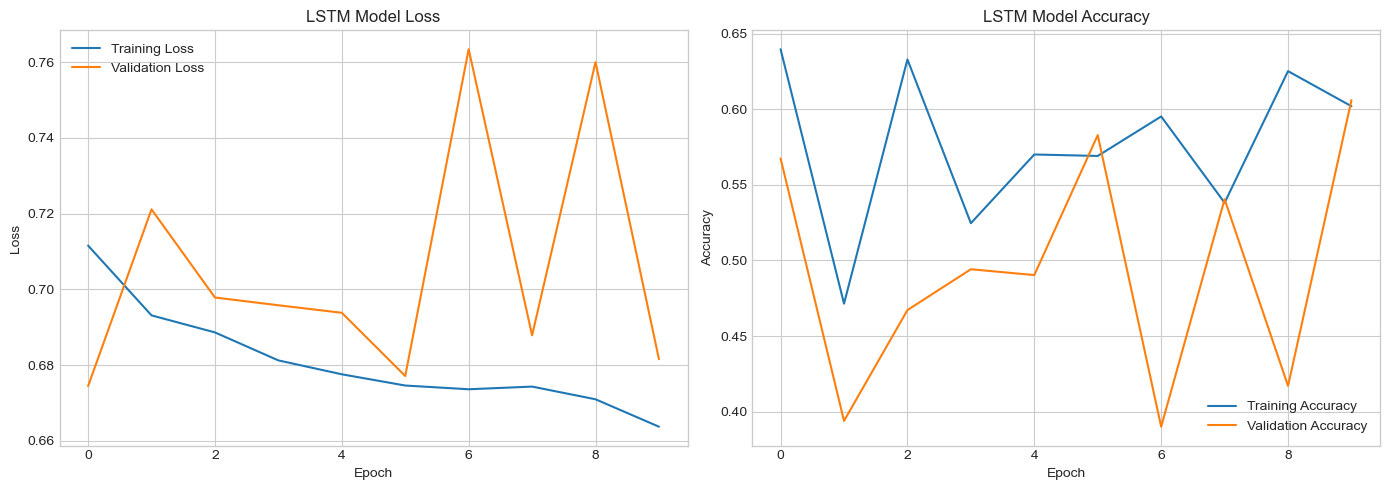

2025-11-06 17:02:41,496, 2919437839.py, 57, INFO, LSTM model training with class weights completed successfully.


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

cw = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_seq)
class_weight = {0: cw[0], 1: cw[1]}

history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

# Make predictions
lstm_pred_prob = lstm_model.predict(X_test_seq)
lstm_pred = (lstm_pred_prob > 0.5).astype(int).flatten()

# Evaluate LSTM model
print("=" * 60)
print("LSTM RESULTS")
print("=" * 60)
print(f"Accuracy: {accuracy_score(y_test_seq, lstm_pred):.4f}")
print(f"ROC-AUC Score: {roc_auc_score(y_test_seq, lstm_pred_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test_seq, lstm_pred))

_logs.info("LSTM model training completed successfully.")

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

_logs.info("LSTM model training with class weights completed successfully.")